   ### ПРОГНОЗ ЦЕНЫ НА НЕДВИЖИМОСТЬ

In [726]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [727]:
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 1000)


In [728]:
train_data_path = '/Users/mac/Desktop/project/train.csv'
test_data_path = '/Users/mac/Desktop/project/test.csv'

# Загрузка данных

#### Описание датасета

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [729]:
train_df = pd.read_csv(train_data_path, index_col='Id')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,B,B,33,7976,5,NaN,0,11,B,"184,966.93"
15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,B,B,46,10309,1,240.00,1,16,B,"300,009.45"
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,B,B,34,7759,0,229.00,1,3,B,"220,925.91"
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,B,B,23,5735,3,"1,084.00",0,5,B,"175,616.23"
10783,99,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,B,B,35,5776,1,"2,078.00",2,4,B,"150,226.53"


In [730]:
test_df = pd.read_csv(test_data_path, index_col='Id')
test_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.00,49.88,33.43,6.00,6,14.00,1972,0.31,B,B,11,2748,1,NaN,0,0,B
15856,74,2.00,69.26,NaN,1.00,6,1.00,1977,0.08,B,B,6,1437,3,NaN,0,2,B
5480,190,1.00,13.60,15.95,12.00,2,5.00,1909,0.00,B,B,30,7538,87,"4,702.00",5,5,B
15664,47,2.00,73.05,51.94,9.00,22,22.00,2007,0.10,B,B,23,4583,3,NaN,3,3,B
14275,27,1.00,47.53,43.39,1.00,17,17.00,2017,0.07,B,B,2,629,1,NaN,0,0,A


In [731]:
train_df.shape, test_df.shape #в трейне есть цена

((10000, 19), (5000, 18))

In [732]:
train_df.dtypes  #3 поля категориальные 

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [733]:
train_df.nunique() #Ecology_2, Ecology_3, Shops_2 можно превратить в количественный признак (0 или 1)

DistrictId         205
Rooms                9
Square           10000
LifeSquare        7887
KitchenSquare       58
Floor               33
HouseFloor          44
HouseYear           97
Ecology_1          129
Ecology_2            2
Ecology_3            2
Social_1            51
Social_2           142
Social_3            30
Healthcare_1        79
Helthcare_2          7
Shops_1             16
Shops_2              2
Price            10000
dtype: int64

In [734]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,"10,000.00","10,000.00","10,000.00","7,887.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","5,202.00","10,000.00","10,000.00","10,000.00"
mean,50.40,1.89,56.32,37.20,6.27,8.53,12.61,"3,990.17",0.12,24.69,"5,352.16",8.04,"1,142.90",1.32,4.23,"214,138.86"
std,43.59,0.84,21.06,86.24,28.56,5.24,6.78,"200,500.26",0.12,17.53,"4,006.80",23.83,"1,021.52",1.49,4.81,"92,872.29"
min,0.00,0.00,1.14,0.37,0.00,1.00,0.00,"1,910.00",0.00,0.00,168.00,0.00,0.00,0.00,0.00,"59,174.78"
25%,20.00,1.00,41.77,22.77,1.00,4.00,9.00,"1,974.00",0.02,6.00,"1,564.00",0.00,350.00,0.00,1.00,"153,872.63"
50%,36.00,2.00,52.51,32.78,6.00,7.00,13.00,"1,977.00",0.08,25.00,"5,285.00",2.00,900.00,1.00,3.00,"192,269.64"
75%,75.00,2.00,65.90,45.13,9.00,12.00,17.00,"2,001.00",0.20,36.00,"7,227.00",5.00,"1,548.00",2.00,6.00,"249,135.46"
max,209.00,19.00,641.07,"7,480.59","2,014.00",42.00,117.00,"20,052,011.00",0.52,74.00,"19,083.00",141.00,"4,849.00",6.00,23.00,"633,233.47"


In [735]:
train_df['Shops_2'].unique() #Категориальные признаки бывают A или B

array(['B', 'A'], dtype=object)

In [736]:
#Заменяем категориальные признаки на 0 или 1

cat_features = ['Shops_2','Ecology_3','Ecology_2']
train_df[cat_features] = train_df[cat_features].replace({'A':0, 'B':1})
test_df[cat_features] = test_df[cat_features].replace({'A':0, 'B':1})

### Обработка пропусков и аномальных значений

In [737]:
train_df.info()   #LifeSquare и Healthcare_1 с пропусками

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  int64  
 10  Ecology_3      10000 non-null  int64  
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  int64  
 18  Pri

In [738]:
#Площадь кухни часто не задана или равна 0,1 и тд
train_df[['Square','LifeSquare','KitchenSquare']].loc[train_df['LifeSquare'].isna()]


,Square,LifeSquare,KitchenSquare
Id,,,
11993,80.31,NaN,0.00
5172,64.51,NaN,1.00
11935,64.71,NaN,1.00
6641,118.91,NaN,0.00
5073,82.67,NaN,1.00
...,...,...,...
16159,38.97,NaN,1.00
2996,64.99,NaN,1.00
15623,55.62,NaN,0.00


In [739]:
#Кореляция между разными видами площади и ценой (малая для жилой площади и кухни)
#train_df.corr()[['Price']]

train_df.corr().loc[['Square', 'LifeSquare', 'KitchenSquare'], 'Price']


Square          0.52
LifeSquare      0.08
KitchenSquare   0.03
Name: Price, dtype: float64

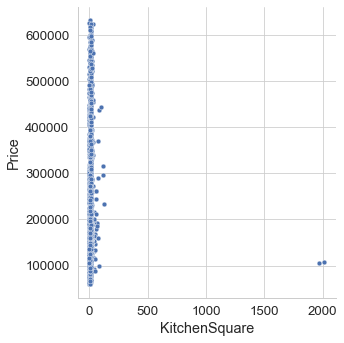

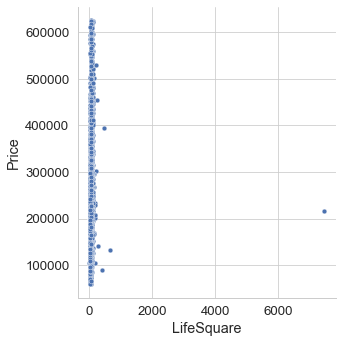

In [740]:
# Есть супербольшие кухни и жил площади

sns.relplot(train_df['KitchenSquare'], train_df['Price'])
sns.relplot(train_df['LifeSquare'], train_df['Price'])

In [741]:
#Строки, где Кухня или Жилая больше общей площади 
train_df.loc[(train_df['LifeSquare'] > train_df['Square'].max())|(train_df['KitchenSquare'] > train_df['Square'].max())]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14656,62,1.00,47.10,46.45,"2,014.00",4,1.00,2014,0.07,1,1,2,629,1,NaN,0,0,0,"108,337.48"
16550,27,3.00,81.69,"7,480.59",1.00,9,17.00,2016,0.02,1,1,2,469,0,NaN,0,0,1,"217,357.49"
14679,81,1.00,32.28,19.28,"1,970.00",6,1.00,1977,0.01,1,1,30,5285,0,645.00,6,6,1,"105,539.56"


In [742]:
# Складываем поля жилой площади и кухни, чтобы обрабатывать как один признак

train_df['LifeSquare'] = train_df['LifeSquare'] + train_df['KitchenSquare']
test_df['LifeSquare'] = test_df['LifeSquare'] + test_df['KitchenSquare']

In [743]:
# Удаляем поле KitchenSquare после объединения

train_df.drop(columns='KitchenSquare', inplace=True)
test_df.drop(columns='KitchenSquare', inplace=True)

In [744]:
train_df.loc[(train_df['LifeSquare'] > train_df['Square'].max())]

,DistrictId,Rooms,Square,LifeSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,
14656,62,1.00,47.10,"2,060.45",4,1.00,2014,0.07,1,1,2,629,1,NaN,0,0,0,"108,337.48"
16550,27,3.00,81.69,"7,481.59",9,17.00,2016,0.02,1,1,2,469,0,NaN,0,0,1,"217,357.49"
11602,30,2.00,641.07,648.16,20,19.00,2019,0.00,1,1,22,6398,141,"1,046.00",3,23,1,"133,529.68"
14679,81,1.00,32.28,"1,989.28",6,1.00,1977,0.01,1,1,30,5285,0,645.00,6,6,1,"105,539.56"


In [745]:
# Там где жилая больше общей заменяем на общую
train_df.loc[(train_df['LifeSquare'] > train_df['Square'].max()), 'LifeSquare'] = train_df['Square']
test_df.loc[(test_df['LifeSquare'] > test_df['Square'].max()), 'LifeSquare'] = test_df['Square']

In [746]:
# Отношение медиан общей площади и жилой.
train_df['LifeSquare'].median()/train_df['Square'].median()

0.7638618658772028

In [747]:
# Заполняем пропуски жилой площади общей площадью, умноженной на отношение медиан этих площадей
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = train_df['Square'] * 0.76386
test_df.loc[test_df['LifeSquare'].isna(), 'LifeSquare'] = test_df['Square'] * 0.76386

In [748]:
train_df.corr()

,DistrictId,Rooms,Square,LifeSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
DistrictId,1.00,0.07,-0.03,-0.03,-0.12,-0.15,0.01,0.07,-0.09,-0.03,0.25,0.17,0.14,0.30,0.31,0.17,-0.02,0.27
Rooms,0.07,1.00,0.66,0.53,-0.00,-0.03,-0.01,-0.03,-0.00,-0.01,0.08,0.07,0.01,0.04,0.06,0.05,-0.00,0.55
Square,-0.03,0.66,1.00,0.83,0.11,0.08,-0.01,-0.06,0.03,0.02,-0.07,-0.04,0.04,-0.04,-0.02,0.02,-0.05,0.52
LifeSquare,-0.03,0.53,0.83,1.00,0.09,0.08,-0.01,-0.06,0.03,0.02,-0.09,-0.07,0.03,-0.02,-0.04,0.01,-0.05,0.39
Floor,-0.12,-0.00,0.11,0.09,1.00,0.42,0.00,-0.02,0.05,0.03,-0.04,-0.02,-0.00,-0.14,-0.07,0.02,-0.01,0.13
HouseFloor,-0.15,-0.03,0.08,0.08,0.42,1.00,-0.00,-0.00,0.06,0.01,-0.02,0.01,-0.01,-0.14,-0.07,0.03,0.05,0.09
HouseYear,0.01,-0.01,-0.01,-0.01,0.00,-0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01,0.01,0.00,0.00,0.00
Ecology_1,0.07,-0.03,-0.06,-0.06,-0.02,-0.00,0.00,1.00,-0.11,-0.22,0.03,0.01,-0.12,-0.04,0.03,-0.08,0.08,-0.06
Ecology_2,-0.09,-0.00,0.03,0.03,0.05,0.06,0.00,-0.11,1.00,-0.02,-0.07,-0.01,0.01,-0.03,-0.08,0.05,0.02,0.02
Ecology_3,-0.03,-0.01,0.02,0.02,0.03,0.01,0.00,-0.22,-0.02,1.00,-0.04,0.01,0.01,-0.11,-0.13,0.00,-0.05,-0.05


In [749]:
# Так как кореляция Healthcare_1 самая высокая с районом, то заменяем пустые значения на среднее по району

train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] =\
    train_df.groupby(['DistrictId'])['Healthcare_1'].transform(lambda x: x.mean())

test_df.loc[test_df['Healthcare_1'].isna(), 'Healthcare_1'] =\
    test_df.groupby(['DistrictId'])['Healthcare_1'].transform(lambda x: x.mean())

In [750]:
# С оставшимися пустыми значениями в Heathcare_1 поступаем так же - заполняем средними значениями в группе, 
# отобранной по признаку Helthcare_2, тк здесь так же наибольшая корреляция

train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] =\
    train_df.groupby(['Helthcare_2'])['Healthcare_1'].transform(lambda x: x.mean())
test_df.loc[test_df['Healthcare_1'].isna(), 'Healthcare_1'] =\
    test_df.groupby(['Helthcare_2'])['Healthcare_1'].transform(lambda x: x.mean())

In [751]:
# Судя по среднему значению в группах по количеству комнат, прослеживается четкая корреляция 
# в группах по 1-2-3-4-5 комнат

pd.concat([train_df.groupby('Rooms')['Price'].apply(lambda x: np.nanmean(x)),
          train_df.groupby('Rooms')['Price'].apply(lambda x: np.nanstd(x)),
          train_df.groupby('Rooms')['Price'].count(),
          train_df.groupby('Rooms')['Price'].apply(lambda x: x.isna().sum())
          ], 
          axis=1, keys=['mean', 'std', 'count', 'nans']).sort_values(by='nans', ascending=False)

,mean,std,count,nans
Rooms,,,,
0.00,"200,435.89","64,611.09",8,0
1.00,"159,850.80","51,885.47",3705,0
2.00,"215,256.31","73,442.74",3880,0
3.00,"289,337.96","104,433.09",2235,0
4.00,"383,251.10","116,790.85",150,0
5.00,"410,431.61","130,785.05",18,0
6.00,"229,661.96",0.00,1,0
10.00,"244,797.30","72,468.03",2,0
19.00,"78,364.62",0.00,1,0


In [752]:
# Судя по ценам заменяем на моду, скорее всего там ошибочные данные

train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] == 6) | \
             (train_df['Rooms'] == 10), 'Rooms'] = train_df['Rooms'].mode()[0]
test_df.loc[(test_df['Rooms'] == 0) | (test_df['Rooms'] == 6) | \
             (test_df['Rooms'] == 10), 'Rooms'] = train_df['Rooms'].mode()[0]

In [753]:
# Заменяем на 1 комнату

train_df.loc[train_df['Rooms'] == 19, 'Rooms'] = 1
test_df.loc[test_df['Rooms'] == 19, 'Rooms'] = 1

In [754]:
pd.concat([train_df.groupby('Rooms')['Price'].apply(lambda x: np.nanmean(x)),
          train_df.groupby('Rooms')['Price'].apply(lambda x: np.nanstd(x)),
          train_df.groupby('Rooms')['Price'].count(),
          train_df.groupby('Rooms')['Price'].apply(lambda x: x.isna().sum())
          ], 
          axis=1, keys=['mean', 'std', 'count', 'nans']).sort_values(by='nans', ascending=False)

,mean,std,count,nans
Rooms,,,,
1.00,"159,828.81","51,895.73",3706,0
2.00,"215,244.72","73,422.23",3891,0
3.00,"289,337.96","104,433.09",2235,0
4.00,"383,251.10","116,790.85",150,0
5.00,"410,431.61","130,785.05",18,0


In [755]:
# По этажам наблюдается разброс средних значений и больших средних отклонений, 
# то есть не видно какой-либо зависимости цены от этого признака.
# Доверимся данным

pd.concat([train_df.groupby('HouseFloor')['Price'].apply(lambda x: np.nanmean(x)),
          train_df.groupby('HouseFloor')['Price'].apply(lambda x: np.nanstd(x)),
          train_df.groupby('HouseFloor')['Price'].count(),
          train_df.groupby('HouseFloor')['Price'].apply(lambda x: x.isna().sum())
          ], 
          axis=1, keys=['mean', 'std', 'count', 'nans']).sort_values(by='nans', ascending=False)

,mean,std,count,nans
HouseFloor,,,,
0.00,"204,397.97","103,733.27",269,0
1.00,"210,420.43","101,490.49",497,0
24.00,"251,162.19","104,581.62",176,0
25.00,"205,644.07","95,426.01",374,0
26.00,"244,668.61",0.00,1,0
27.00,"291,783.96","156,734.95",6,0
28.00,"248,459.72","91,091.91",3,0
29.00,"131,477.02",0.00,1,0
30.00,"354,135.92","120,984.70",21,0


In [756]:
# Заменяем аномальные года на "подходящие"

train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2011
train_df.loc[train_df['HouseYear'] == 4968, 'HouseYear'] = 1968

### Построение новых признаков

In [757]:
# Цена за один квадратный метр

train_df['Price_per_square'] = train_df['Price'] / train_df['Square']

In [758]:
# Средняя цена за метр по району

price_per_metr_by_district = train_df.groupby(train_df['DistrictId'], as_index=False)\
.agg({'Price_per_square':'median'}).rename(columns={'Price_per_square':'Price_per_square_by_district'})

In [759]:
# Добавляем поле цена за квадратный метр по району 

train_df = train_df.merge(price_per_metr_by_district, on=['DistrictId'], how='left').set_index(train_df.index)
test_df = test_df.merge(price_per_metr_by_district, on=['DistrictId'], how='left').set_index(test_df.index)

In [760]:
# Так как в тестовом наборе оказалось больше районов, то 8 ячеек оказались NaN, поэтому запоняем их
# медианными значениями из тренировочного набора (с 198 района добавляется несколько районов в тесте)

test_df.loc[test_df['Price_per_square_by_district'].isna(), 'Price_per_square_by_district'] = \
train_df.loc[train_df['DistrictId']  > 198]['Price_per_square'].median()

### Отбор признаков

In [761]:
train_df.to_csv('train_prepared.csv')
test_df.to_csv('test_prepared.csv')

In [762]:
# Корреляция по признакам

train_df.corr().loc['Price']

DistrictId                      0.27
Rooms                           0.57
Square                          0.52
LifeSquare                      0.39
Floor                           0.13
HouseFloor                      0.09
HouseYear                       0.04
Ecology_1                      -0.06
Ecology_2                       0.02
Ecology_3                      -0.05
Social_1                        0.26
Social_2                        0.24
Social_3                        0.07
Healthcare_1                    0.21
Helthcare_2                     0.25
Shops_1                         0.18
Shops_2                         0.07
Price                           1.00
Price_per_square                0.24
Price_per_square_by_district    0.53
Name: Price, dtype: float64

In [763]:
feature_names = [feature for feature in train_df.columns if feature not in ['Price', 'Price_per_square']]
len(feature_names)

18

In [764]:
# Матрица наблюдений и целевая переменая
X = train_df[feature_names]
y = train_df['Price']

### Построение модели Random Forest

In [765]:
forest = RandomForestRegressor(random_state=77)
kf = KFold(n_splits=5, random_state=77, shuffle=True)
cv_score = cross_val_score(forest, X, y, scoring='r2', cv=kf)
print('R2: {:.5f}'.format(cv_score.mean()))

R2: 0.74408


#### Важность признаков

In [766]:
forest.fit(X,y)
importances = forest.feature_importances_
feature_importances = pd.DataFrame(importances, index=feature_names)
feature_importances.sort_values(by=0,ascending=True, inplace=True)

<AxesSubplot:>

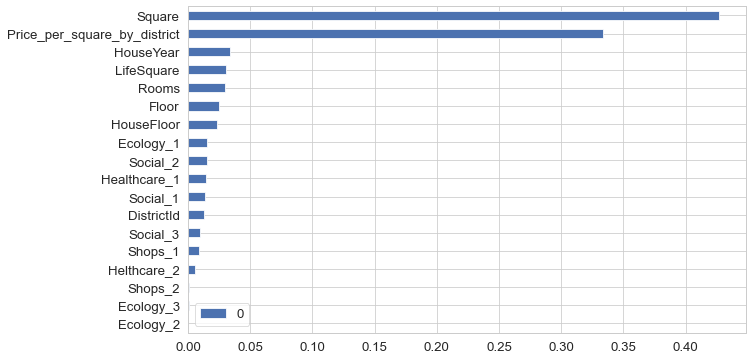

In [767]:
feature_importances.plot(kind='barh', figsize=(10, 6))

### Отбор признаков методом RFE

In [768]:
X_full = train_df[feature_names]

from sklearn.feature_selection import RFE

rfe = RFE(estimator=forest, 
          n_features_to_select=13,
          step=2)

rfe.fit(X_full, y)
X_full.columns[rfe.support_]

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
       'Healthcare_1', 'Price_per_square_by_district'],
      dtype='object')

In [769]:
for n in range(13, 15, 1):
    rfe = RFE(forest, n_features_to_select=n, step=2)
    X_new = rfe.fit_transform(X_full, y)
    scores = cross_val_score(forest, X_new, y, scoring='r2', cv=kf)
    print('n_features_to_select: {} - R2: {:.5}'.format(n, scores.mean())) 

n_features_to_select: 13 - R2: 0.74489
n_features_to_select: 14 - R2: 0.74385


In [770]:
X_full.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1',
       'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1',
       'Shops_2', 'Price_per_square_by_district'],
      dtype='object')

In [771]:
# Признаки которые автоматически отобрали

feature_names = X_full.columns[rfe.support_]

### Настройка гиперпараметров модели

In [772]:
params = {
    'max_depth': [14,15,16],
    'max_features': [3,4,5]
}

# Оптимальное количество признаков 13
X = train_df[feature_names]

In [773]:
forest_grid = GridSearchCV(forest, params, scoring='r2', 
                  cv=KFold(n_splits=5, random_state=77, shuffle=True), 
                  n_jobs=-1)
forest_grid.fit(X, y)
print(forest_grid.best_params_)
print('R2 на train: {:.5f}'.format(forest_grid.best_score_)) 

{'max_depth': 15, 'max_features': 4}
R2 на train: 0.75526


## Прогнозирование на тестовом датасете

In [774]:
test_df[feature_names].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DistrictId                    5000 non-null   int64  
 1   Rooms                         5000 non-null   float64
 2   Square                        5000 non-null   float64
 3   LifeSquare                    5000 non-null   float64
 4   Floor                         5000 non-null   int64  
 5   HouseFloor                    5000 non-null   float64
 6   HouseYear                     5000 non-null   int64  
 7   Ecology_1                     5000 non-null   float64
 8   Social_1                      5000 non-null   int64  
 9   Social_2                      5000 non-null   int64  
 10  Social_3                      5000 non-null   int64  
 11  Healthcare_1                  5000 non-null   float64
 12  Shops_1                       5000 non-null   int64  
 13  

In [775]:
forest_best = RandomForestRegressor(max_depth=15,
                                    max_features=4,
                                    random_state=77)
forest_best.fit(X, y)
y_pred = forest_best.predict(test_df[feature_names])
y_pred

array([170500.11367399, 233290.14118303, 282656.04441619, ...,
       318592.61572905, 195181.69175378, 173295.33043822])

In [776]:
preds = pd.DataFrame()
preds['Id'] = test_df.index
preds['Price'] = y_pred
preds.head()

,Id,Price
0,725,"170,500.11"
1,15856,"233,290.14"
2,5480,"282,656.04"
3,15664,"303,338.24"
4,14275,"145,674.29"


In [779]:
preds.to_csv('submission_01.csv', index=False)

In [780]:
preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      5000 non-null   int64  
 1   Price   5000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 78.2 KB
